In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os

In [2]:
absolute_path = os.path.join(os.getcwd(), '/mnist')

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST(os.getcwd(), transform=transform, download=True)
test_dataset  = MNIST(os.getcwd(), transform=transform, download=True)

In [4]:
def plot_image(tensor):

    if tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)

    image = tensor.numpy()


    plt.imshow(image, cmap='gray' if tensor.ndim == 2 else None)
    plt.axis('off')
    plt.show()

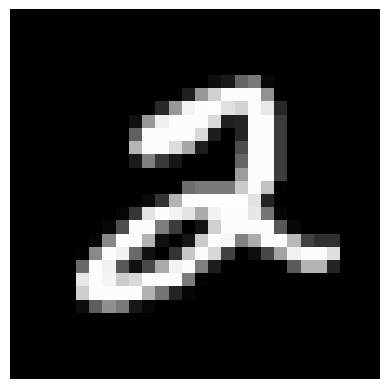

In [5]:
plot_image(train_dataset[5][0])

# Autoencoder:

In [6]:
class AutoEncodingVariationalBayes(nn.Module):
    def __init__(self, input_dim, hidden_layers):
        super(AutoEncodingVariationalBayes, self).__init__()

        self.input_dim = input_dim
        self.hidden_layers = hidden_layers

        inter_dim = 32
        self.encoder_mlp = nn.Sequential(
            nn.Linear(self.input_dim, inter_dim), # Here are the weights W_3 that make up phi
            nn.Tanh(),
        )

        self.latent_u_prediction_head = nn.Linear(inter_dim, hidden_layers) # Here are the weights W_4 that make up phi
        self.latent_sigma_prediction_head = nn.Linear(inter_dim, hidden_layers) # Here are the weights W_5 that make up phi

        self.decoder_mlp = nn.Sequential(
            nn.Linear(input_dim, inter_dim),
            nn.Tanh()
        )

        self.ouput_u_prediction_head = nn.Linear(hidden_layers, input_dim)
        self.output_sigma_prediction_head = nn.Linear(hidden_layers, input_dim)

    def encoder_forward(self, X):
        h = self.encoder_mlp(X)
        latent_u = self.latent_u_prediction_head(h)
        latent_sigma = self.latent_sigma_prediction_head(h)

        return latent_u, latent_sigma # These are the estimates of parameters for q_phi(Z|X) ~ N(latent_u, latent_sigma)

    def decoder_forward(self, latent_u, latent_sigma, sampled_error_e = 0):
        Z = latent_u + latent_sigma*sampled_error_e # Latent variables Z
        # We sample from prior only during training, so during prediction Z = latent_u

        h = self.decoder_mlp(Z)
        output_u = self.output_u_prediction_head(h) # This is the main prediction of X_hat
        output_sigma = self.output_sigma_prediction_head(h) # Not needed to reconstruct, but gives us an estimate of the variance

        return output_u, output_sigma # These are the estimates of parameters for p_theta(X|Z) ~ N(output_u, output_sigma)

    def sample_from_prior(self):
        samples = torch.randn(self.hidden_layer) # This is a prior p(Z) ~ N(0,1)
        return samples

    def forward(self, X):
        latent_u, latent_sigma = self.encoder_forward(X)
        sampled_error_e = self.sample_from_prior()
        X_hat, variance = self.decoder_forward(latent_u, latent_sigma, sampled_error_e)
        return X_hat, variance, latent_u, latent_sigma

In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)